# 2D simulation with SPECFEM2D
By Andrea R. using utility functions written by Ridvan Orsvuran

In [7]:
import os
import re

import matplotlib.pyplot as plt
import numpy as np
import obspy
import IPython.display as dp
from PIL import Image
from scipy.integrate import simps

In [8]:
# Some utility functions (written by Ridvan Orsvuran)
def read_trace(filename):
    """Reads an ASCII file and returns a obspy Traces"""
    data = np.loadtxt(filename)
    # first column is time, second column is the data
    times = data[:, 0]
    disp = data[:, 1]
    # get station name from the filename
    net, sta, comp, *_ = filename.split("/")[-1].split(".")
    delta = times[1] - times[0]
    headers = {"station": sta, "network": net, "channel": comp, "delta": delta, "b": times[0]}
    return obspy.Trace(disp, headers)

def save_trace(tr, filename):
    """Writes out the traces as an ASCII file. Uses b value as the beginning."""
    data = np.zeros((len(tr.data), 2))
    data[:, 0] = tr.times()+tr.stats.b
    data[:, 1] = tr.data
    np.savetxt(filename, data)
       
def specfem_write_parameters(filename, parameters, output_file=None):
    """Write parameters to a specfem config file"""

    with open(filename) as f:
        pars = f.read()

    for varname, value in parameters.items():
        pat = re.compile(
            r"(^{varname}\s*=\s*)([^#$\s]+)".format(varname=varname),
            re.MULTILINE)
        pars = pat.sub(r"\g<1>{value}".format(value=value), pars)

    if output_file is None:
        output_file = filename

    with open(output_file, "w") as f:
        f.write(pars)     
        
def specfem2D_prep_save_forward(filename=None):
    if filename is None:
        filename = "./DATA/Par_file"
    params = {
        "SIMULATION_TYPE": 1,
        "SAVE_FORWARD": ".true."
    }
    specfem_write_parameters(filename, params)
    
def specfem2D_prep_adjoint(filename=None):
    if filename is None:
        filename = "./DATA/Par_file"
    params = {
        "SIMULATION_TYPE": 3,
        "SAVE_FORWARD": ".false."
    }
    specfem_write_parameters(filename, params)
      
def grid(x, y, z, resX=100, resY=100):
    """
    Converts 3 column data to matplotlib grid
    """
    # Can be found in ./utils/Visualization/plot_kernel.py
    from scipy.interpolate import griddata

    xi = np.linspace(min(x), max(x), resX)
    yi = np.linspace(min(y), max(y), resY)

    # mlab version
    #Z = griddata(x, y, z, xi, yi, interp='linear')
    # scipy version
    Z = griddata((x, y), z, (xi[None,:], yi[:,None]), method='cubic')

    X, Y = np.meshgrid(xi, yi)
    return X, Y, Z

### Domain: 
2D:   
x-dir = 4000 m   
z-dir = 4000 m   

### Source location
original x:    1000 m     
original z:    2000 m  

### Output station location: 
Station #1   AAS0001                             
original x:    3000 m  
original z:    2000 m  

### Boundary conditions 
Type: STACEY_ABSORBING_CONDITIONS  
absorbbottom                    = true  
absorbright                     = true  
absorbtop                       = true  
absorbleft                      = true  

### Velocity model:

Model: P (or PI) velocity min,max =    3000 m/s              
Model: S velocity min,max         =    1800 m/s        
Model: density min,max            =    2700 kg/m3           

### To reproduce this example copy the files in DATA to the specfem2d directory: specfem2d/DATA

### Set Specfem2D directory path

In [9]:
specfem2d_path = "/media/data/Gits/fwi/homework/assignment_2"

In [10]:
specfem2d_bin = "/media/data/Gits/fwi/bin"

### 1. Run the mesher

In [11]:
os.chdir(specfem2d_path)
!$specfem2d_bin/xmeshfem2D


 **********************************************
 *** Specfem 2-D Mesher - MPI version       ***
 **********************************************

 Running Git version of the code corresponding to fd7926e7eae5f9c0f614cf7d06e56c768ca3a9a4
 dating 2022-12-13 20:03:51 +0100

 Reading the parameter file...

 Title of the simulation: Test of SPECFEM2D with curved interfaces


 Receiver lines:
   Nb of line sets =            2

 Materials:
   Nb of solid, fluid or porous materials =            4

 --------
 Material #           1  isotropic
 rho,cp,cs   =    2700.0000000000000        3000.0000000000000        1732.0509999999999     
 Qkappa, Qmu =    9999.0000000000000        9999.0000000000000     
 Material is solid
 --------
 Material #           2  isotropic
 rho,cp,cs   =    2500.0000000000000        2700.0000000000000        0.0000000000000000     
 Qkappa, Qmu =    9999.0000000000000        9999.0000000000000     
 Material is fluid
 --------
 Material #           3  isotropic
 rho,cp,

### 2. Run the solver

In [14]:
!$specfem2d_bin/xspecfem2D


 **********************************************
 **** Specfem 2-D Solver - MPI version     ****
 **********************************************

 Running Git version of the code corresponding to fd7926e7eae5f9c0f614cf7d06e56c768ca3a9a4
 dating 2022-12-13 20:03:51 +0100

 There are            1  MPI processes
 Processes are numbered from 0 to            0

 There is a total of            1  slices


 NDIM =            2

 NGLLX =            5
 NGLLZ =            5

 using single precision for the calculations

 smallest and largest possible floating-point numbers are:    1.17549435E-38   3.40282347E+38

 Reading the parameter file...

 Title of the simulation: Test of SPECFEM2D with curved interfaces


 Parameter file successfully read 

 Reading in SOURCE file...

 Source           1
   Position xs, zs =    2500.0000000000000        2500.0000000000000     

   Source type (1=force, 2=moment tensor):            1
   Force source:
   Angle of the source (deg) =    0.0000000000000000    

### 3. Plot synthetic seismogram

In [16]:
# Read synthetic seismogram
synt = read_trace("./OUTPUT_FILES/AA.S0001.BXX.semd")

# Process data
synt.detrend("simple")
synt.taper(0.05)
synt.filter("bandpass", freqmin=0.01, freqmax=20)

fig, ax = plt.subplots(figsize=(20, 4))
# Use the beginning time value from the file: tr.times()+tr.stats.b
ax.plot(synt.times()+synt.stats.b, synt.data, "r", label="synt")
ax.set_xlim(synt.stats.b, synt.times()[-1]+synt.stats.b)
ax.legend()
ax.set_xlabel("Time (s)");
ax.set_ylabel("Displacement (m)");

ImportError: Could not load shared library "signal"
      /media/data/Gits/obspy/obspy/lib/signal.cpython-38-x86_64-linux-gnu.so: cannot open shared object file: No such file or directory
      /media/data/Gits/obspy/obspy/lib/signal.abi3.so: cannot open shared object file: No such file or directory
      /media/data/Gits/obspy/obspy/lib/signal.so: cannot open shared object file: No such file or directory
  Current directory: /media/data/Gits/fwi/homework/assignment_2
  Directory listing of lib directory:
      /media/data/Gits/obspy/obspy/lib/__init__.py
      /media/data/Gits/obspy/obspy/lib/__pycache__
      /media/data/Gits/obspy/obspy/lib/libevresp_Linux_64bit_py27.so
      /media/data/Gits/obspy/obspy/lib/libevresp_Linux_64bit_py37.cpython-37m-x86_64-linux-gnu.so
      /media/data/Gits/obspy/obspy/lib/libevresp_Linux_64bit_py38.cpython-38-x86_64-linux-gnu.so
      /media/data/Gits/obspy/obspy/lib/libgse2_Linux_64bit_py27.so
      /media/data/Gits/obspy/obspy/lib/libgse2_Linux_64bit_py37.cpython-37m-x86_64-linux-gnu.so
      /media/data/Gits/obspy/obspy/lib/libgse2_Linux_64bit_py38.cpython-38-x86_64-linux-gnu.so
      /media/data/Gits/obspy/obspy/lib/libmseed_Linux_64bit_py27.so
      /media/data/Gits/obspy/obspy/lib/libmseed_Linux_64bit_py37.cpython-37m-x86_64-linux-gnu.so
      /media/data/Gits/obspy/obspy/lib/libmseed_Linux_64bit_py38.cpython-38-x86_64-linux-gnu.so
      /media/data/Gits/obspy/obspy/lib/libsegy_Linux_64bit_py27.so
      /media/data/Gits/obspy/obspy/lib/libsegy_Linux_64bit_py37.cpython-37m-x86_64-linux-gnu.so
      /media/data/Gits/obspy/obspy/lib/libsegy_Linux_64bit_py38.cpython-38-x86_64-linux-gnu.so
      /media/data/Gits/obspy/obspy/lib/libsignal_Linux_64bit_py27.so
      /media/data/Gits/obspy/obspy/lib/libsignal_Linux_64bit_py37.cpython-37m-x86_64-linux-gnu.so
      /media/data/Gits/obspy/obspy/lib/libsignal_Linux_64bit_py38.cpython-38-x86_64-linux-gnu.so
      /media/data/Gits/obspy/obspy/lib/libtau_Linux_64bit_py27.so
      /media/data/Gits/obspy/obspy/lib/libtau_Linux_64bit_py37.cpython-37m-x86_64-linux-gnu.so
      /media/data/Gits/obspy/obspy/lib/libtau_Linux_64bit_py38.cpython-38-x86_64-linux-gnu.so

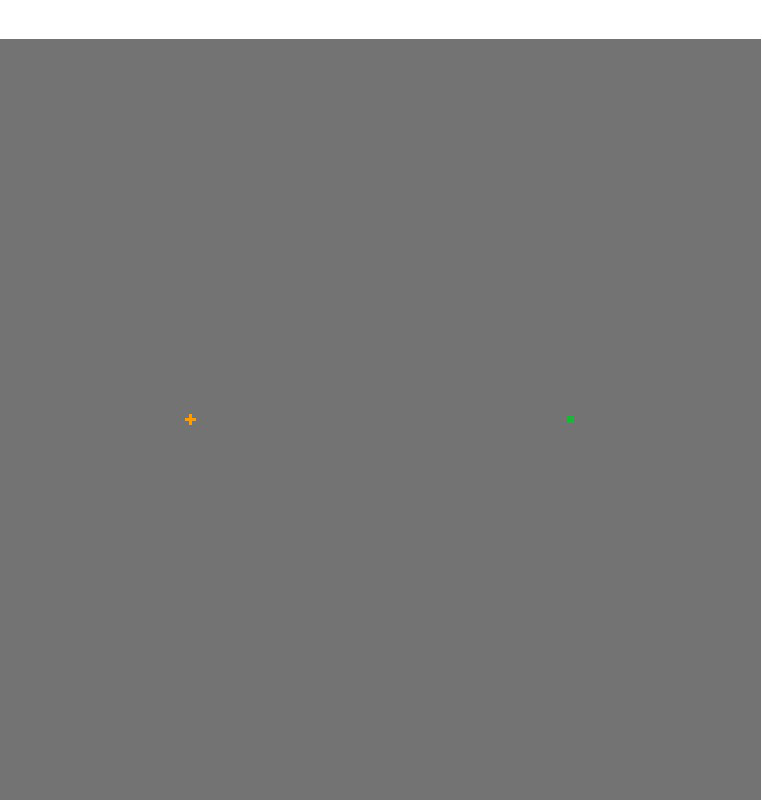

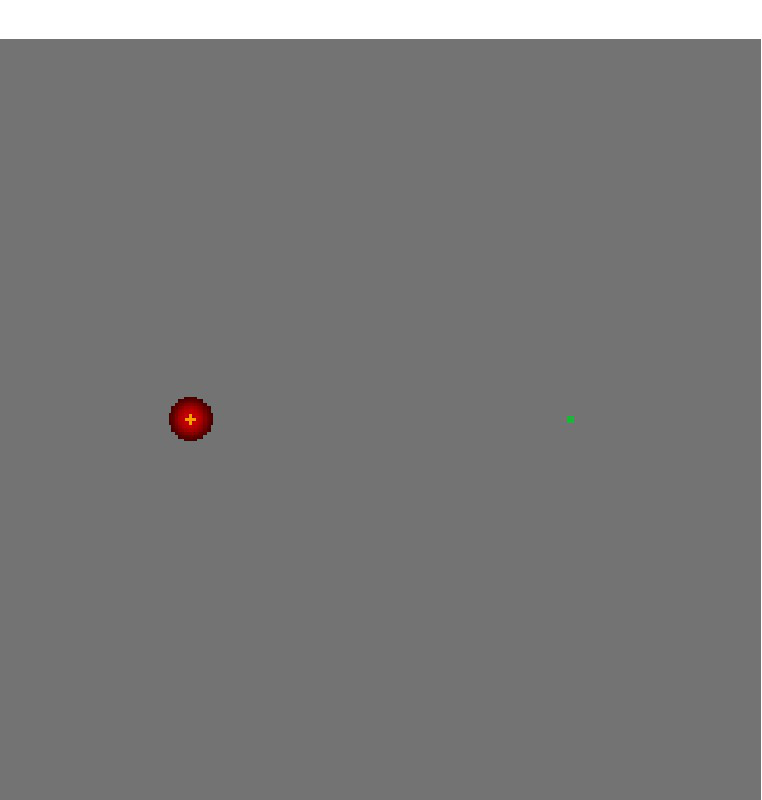

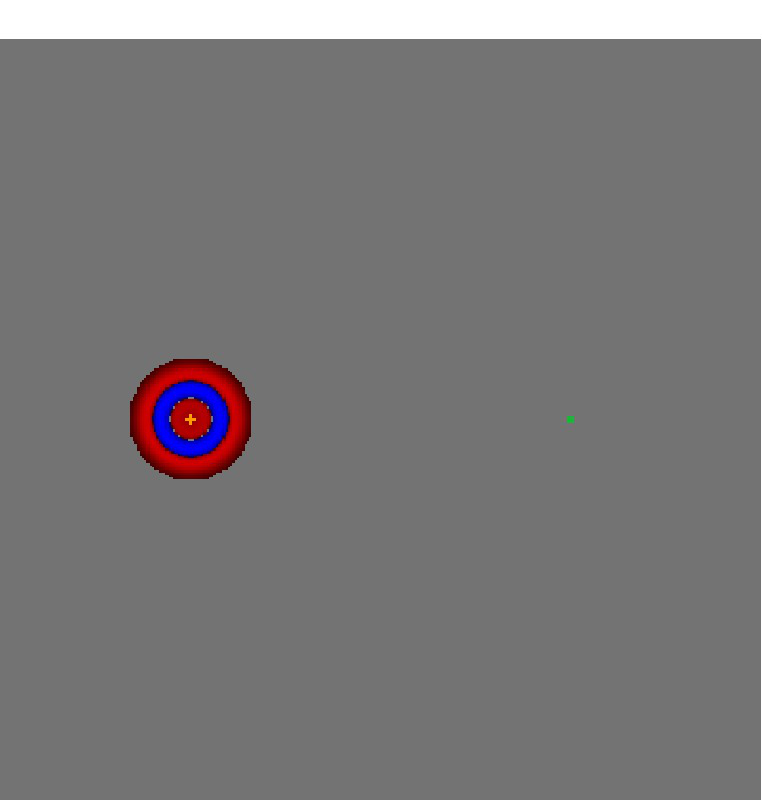

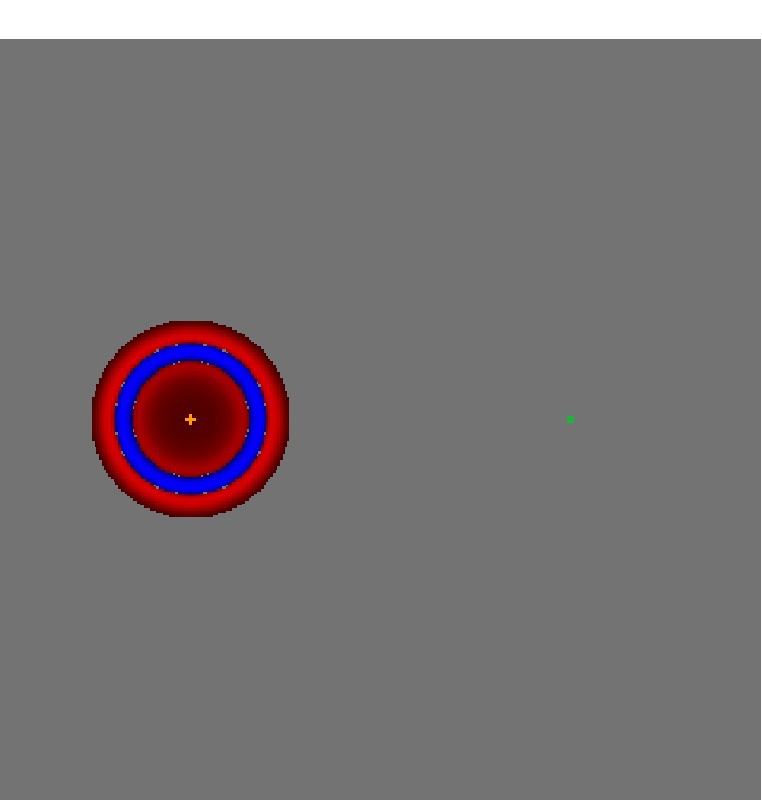

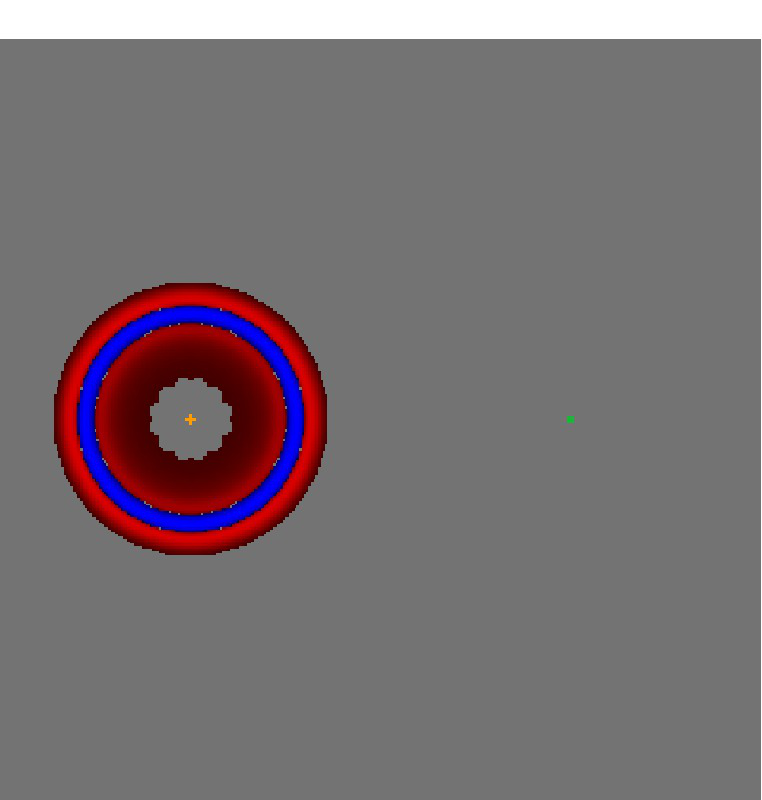

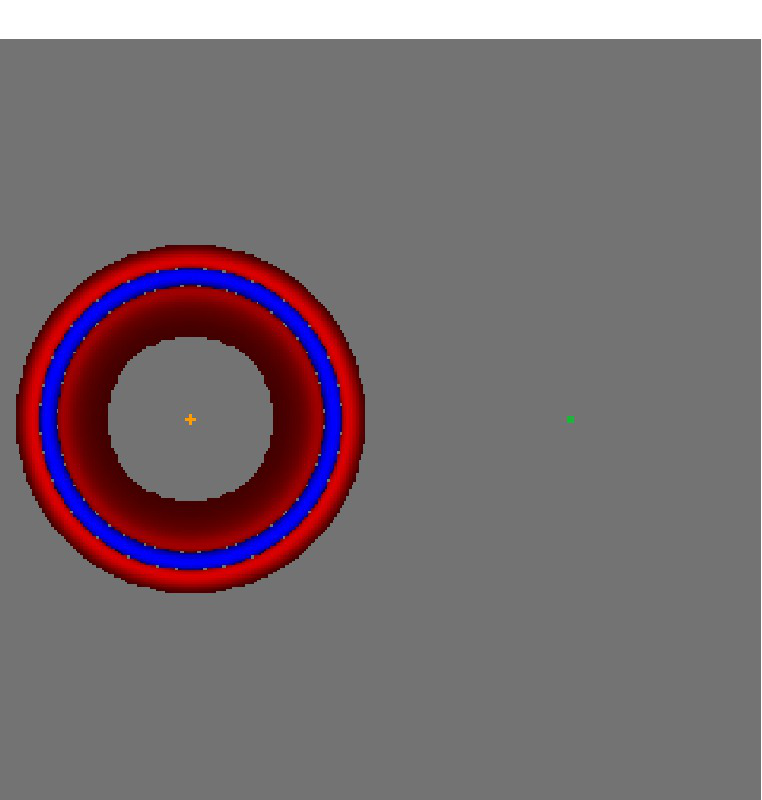

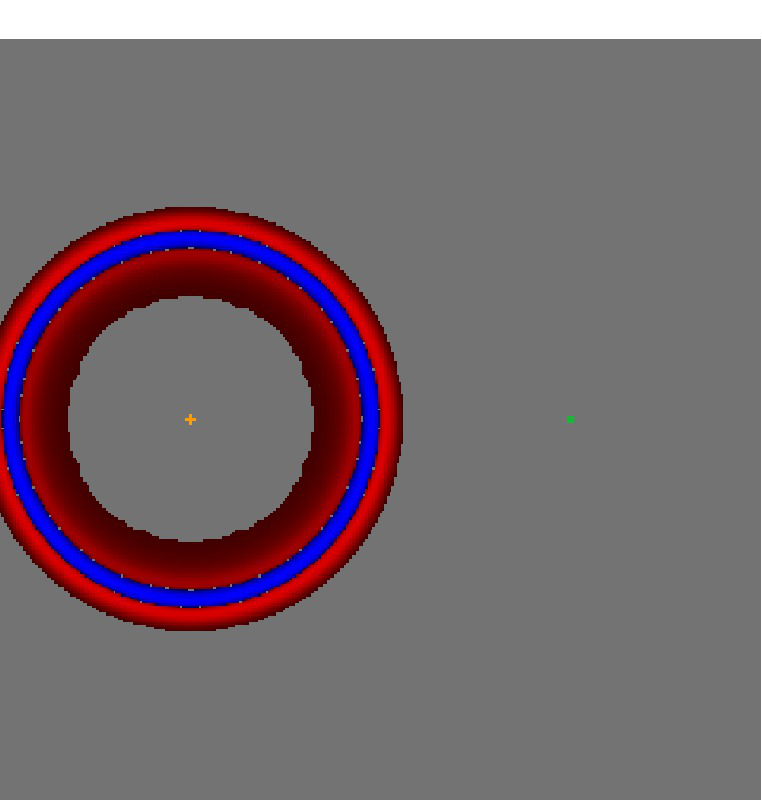

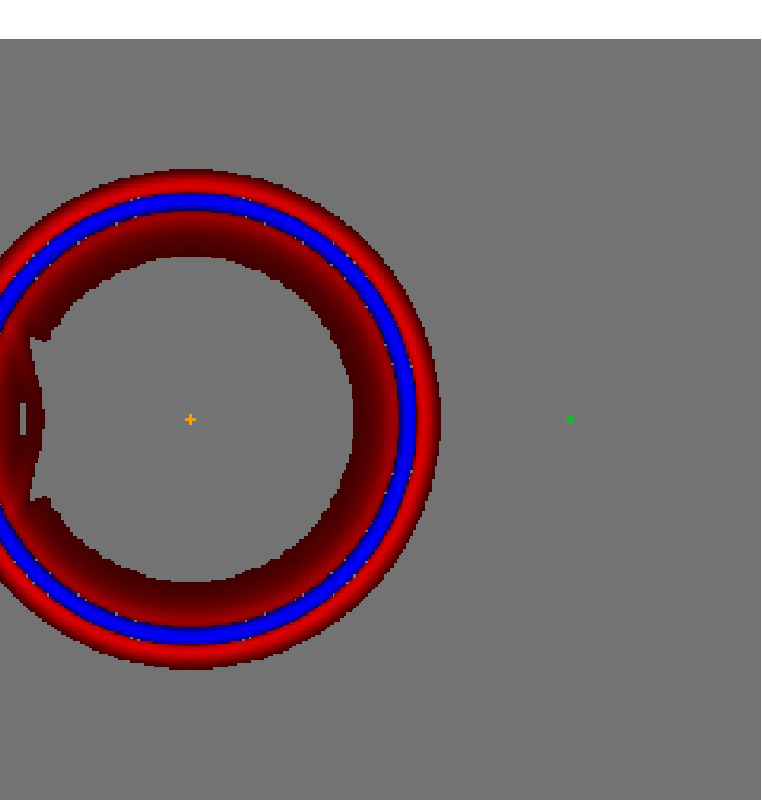

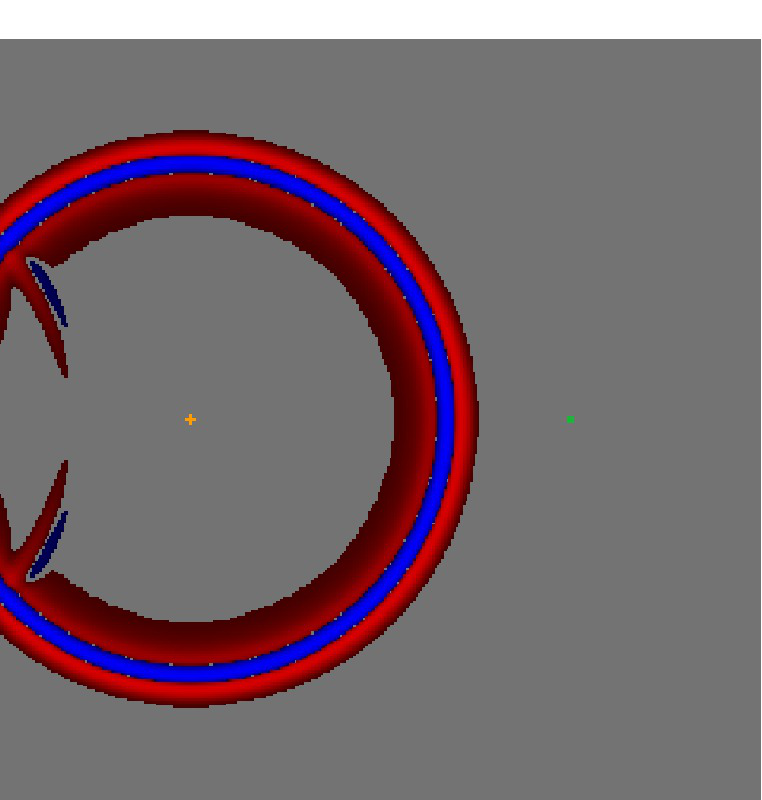

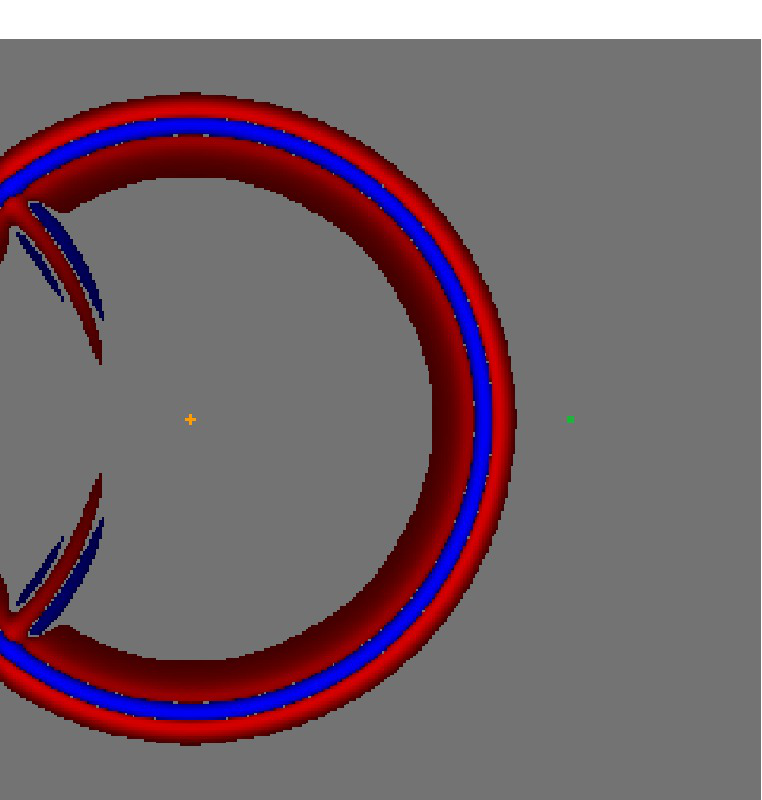

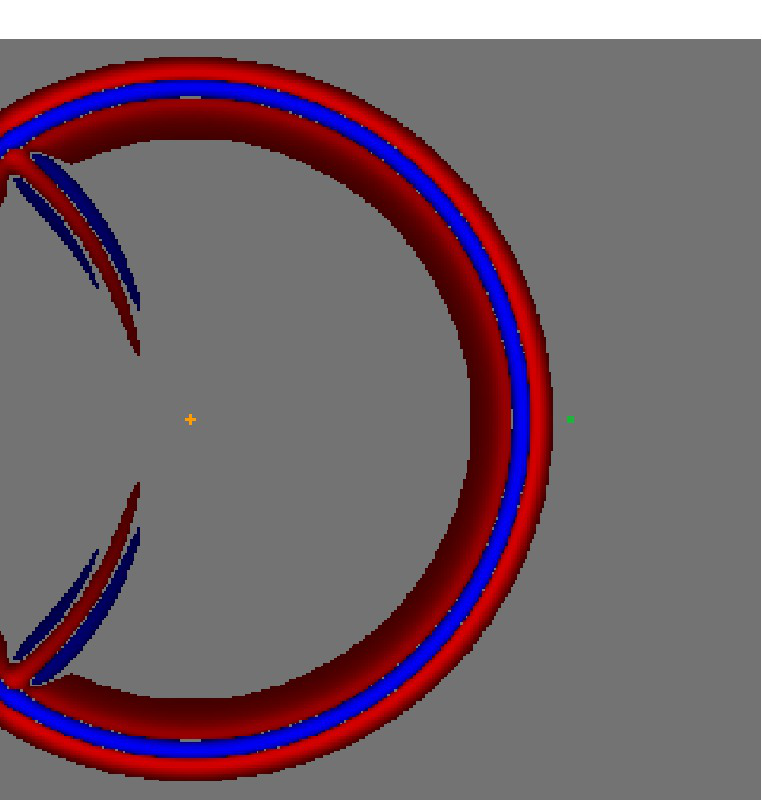

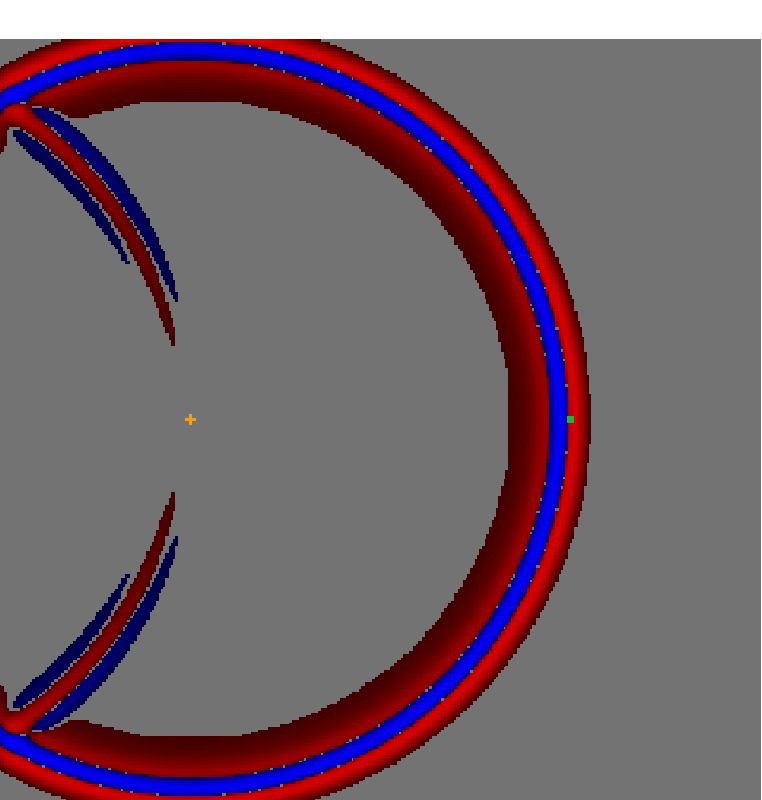

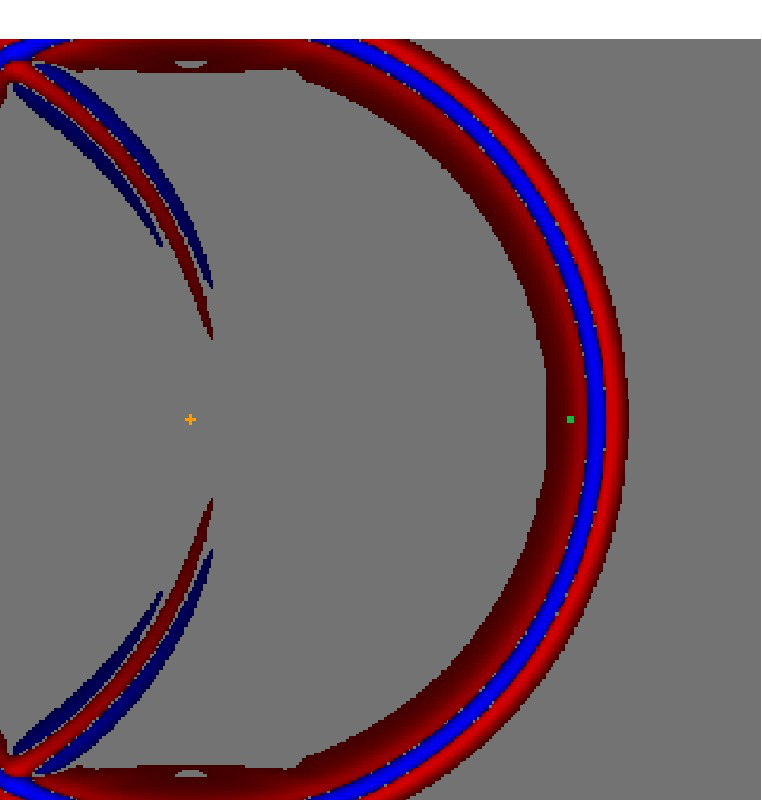

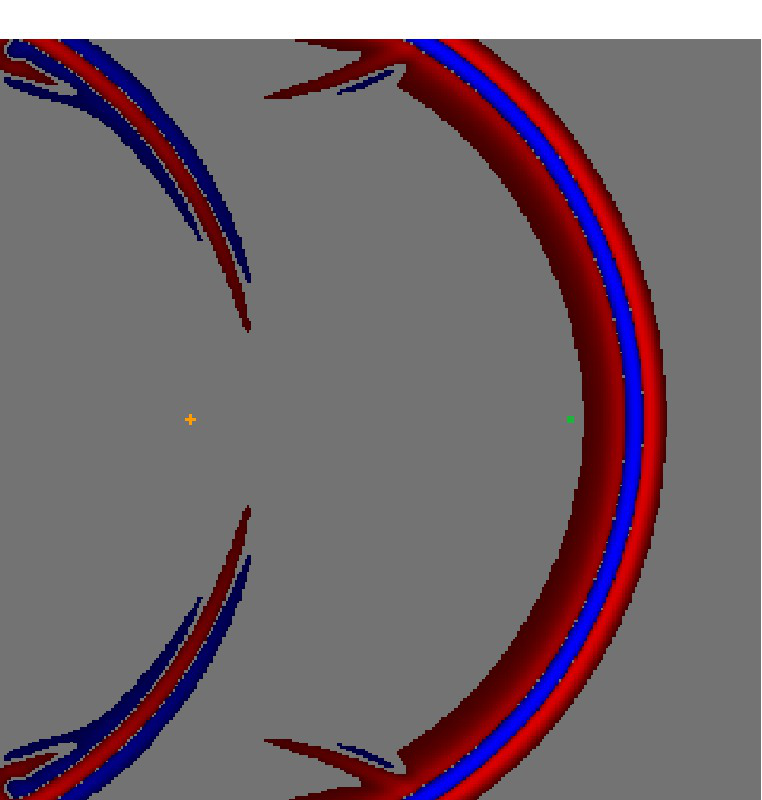

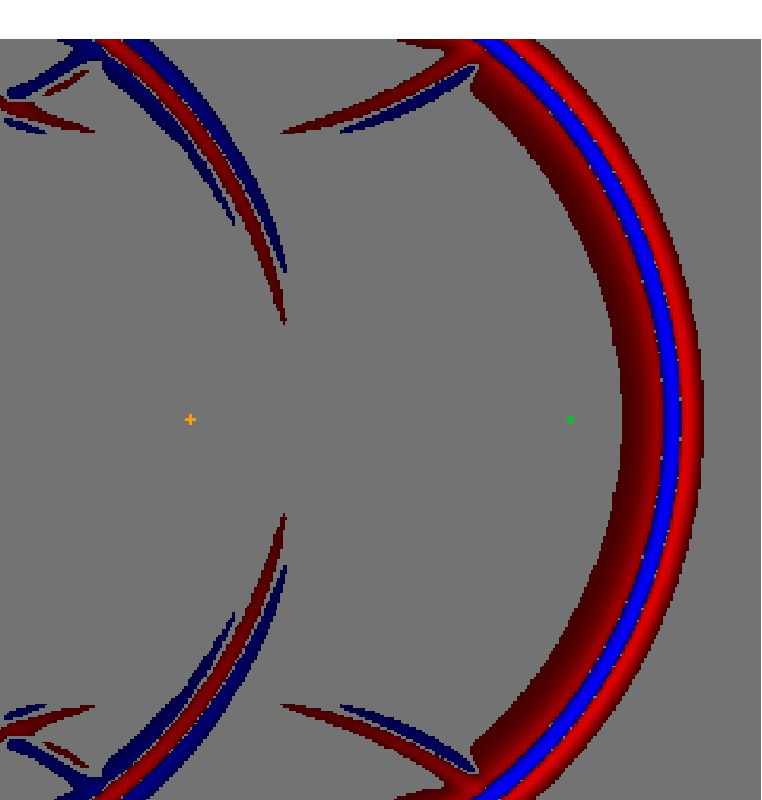

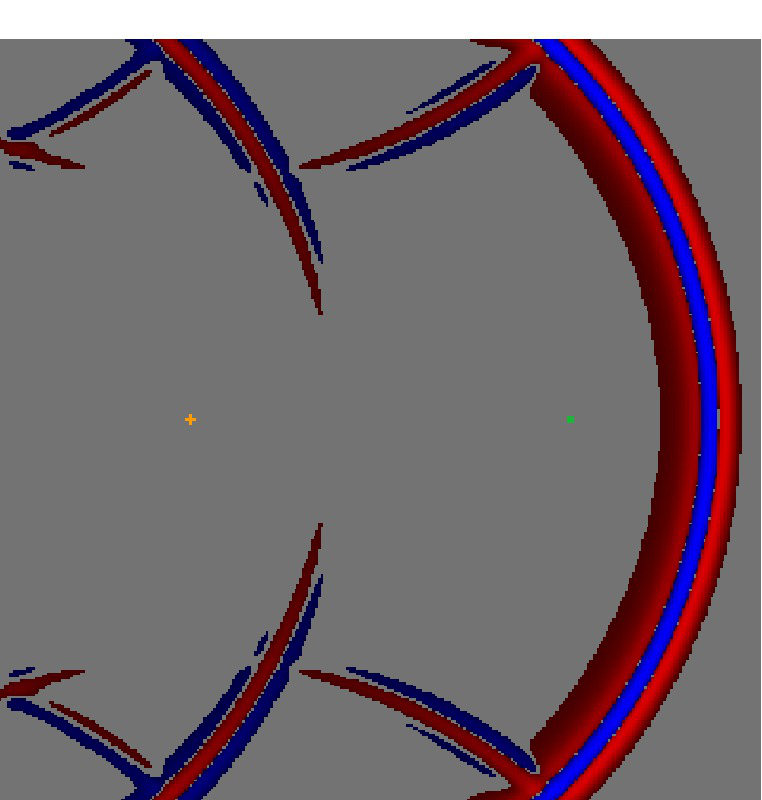

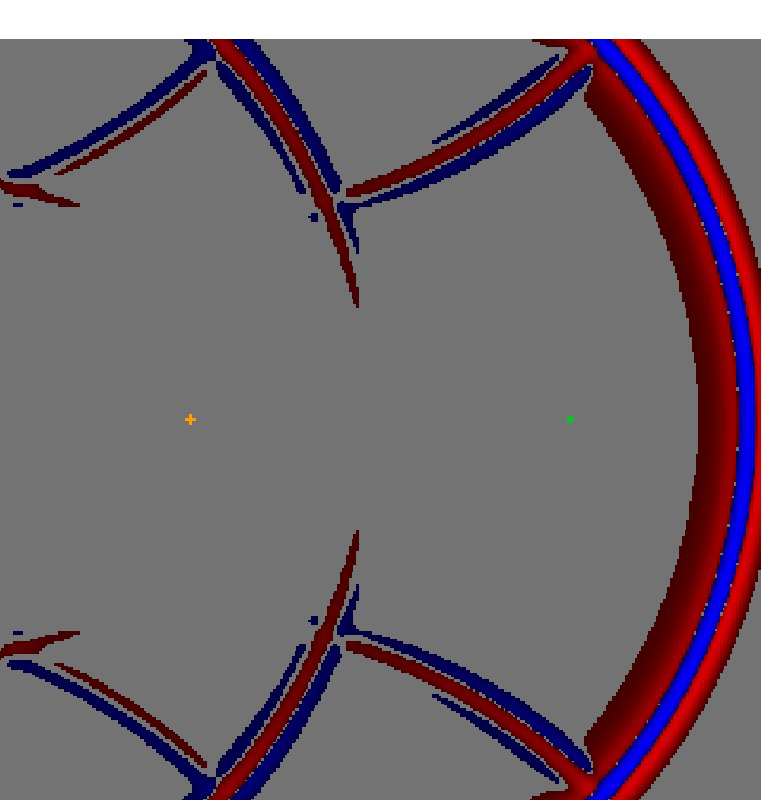

In [ ]:
### 4. Snapshots 
images=[]
# collect all .jpg files in OUTPUT_FILES directory
fs = !ls OUTPUT_FILES/*.jpg
# Print .jpg files
for ea in fs:
    images.append(dp.Image(filename=ea,format='jpg'))
for ea in fs:
    dp.display(Image.open(ea))